In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [2]:
import os
import numpy as np
import tqdm
import time
import pathlib

import tensorflow as tf

from scrinet.fits.nn import RegressionANN

In [3]:
import schwimmbad
import functools
import tqdm

In [4]:
# import sys
# sys.path.append("/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline")
from pipe_utils import init_logger, load_data

In [5]:
from evaluate_model import match, wave_sur_many, load_model

In [6]:
import generators

In [7]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
def upsample(x, y, npts=None):
    new_x = np.linspace(x[0], x[-1], npts)
    iy = IUS(x, y)
    return new_x, iy(new_x)

def resample(x, y, new_x):
    iy = IUS(x, y)
    return new_x, iy(new_x)

In [339]:
def wave_sur_many(qs, chi1x, chi1z, amp_model, amp_basis, phase_model, phase_basis, times=None):
    
#     default_times = np.linspace(-10000, 100, 5000)
    default_times = np.linspace(-1000, 100, 1000)
    if times is not None:
        #resample basis
        new_amp_basis = np.zeros(shape=(amp_basis.shape[0], len(times)))
        for i in range(amp_basis.shape[0]):
            _, new_amp_basis[i] = resample(default_times, amp_basis[i], times)
        amp_basis = new_amp_basis
            
        new_phase_basis = np.zeros(shape=(phase_basis.shape[0], len(times)))
        for i in range(phase_basis.shape[0]):
            _, new_phase_basis[i] = resample(default_times, phase_basis[i], times)
        phase_basis = new_phase_basis
    else:
        times = default_times
    
    pars = np.array(list(zip(qs, chi1x, chi1z)))
    pars[:,0] = np.log(pars[:,0]) # need to log the mass-ratio

    amp_alpha = amp_model.predict(pars)
    amp = np.dot(amp_alpha, amp_basis)

    phase_alpha = phase_model.predict(pars)
    phase = np.dot(phase_alpha, phase_basis)

    h = amp * np.exp(-1.j * phase)
#### HACK
#     h = amp - 1.j * phase
#     amp = np.abs(h)
#     phase = np.unwrap(np.angle(h))

    return np.real(h), np.imag(h), amp, phase, times

In [340]:
pwd

'/nfshome/store01/users/sebastian.khan/git/stk/scrinet/bin/dev/pipeline'

In [341]:
# rootdir = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run/run'
# rootdir = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run-3d/run'
rootdir = '/scratch/sebastian.khan/scrinet-3d-prec-test-output/'

In [342]:
amp_basis = os.path.join(rootdir, 'rb/amp/amp_eim_basis.npy')
amp_model_dir = os.path.join(rootdir, 'ts/amp/fits')

phase_basis = os.path.join(rootdir, 'rb/phase/phase_eim_basis.npy')
phase_model_dir = os.path.join(rootdir, 'ts/phase/fits')

In [343]:
amp_model, amp_basis = load_model(
    basis_file=amp_basis,
    nn_weights_file=os.path.join(amp_model_dir, "best.h5"),
    X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(amp_model_dir, "Y_scalers.npy"))

phase_model, phase_basis = load_model(
    basis_file=phase_basis,
    nn_weights_file=os.path.join(phase_model_dir, "best.h5"),
    X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(phase_model_dir, "Y_scalers.npy"))

In [361]:
default_times = np.linspace(-1000, 100, 1000)

In [356]:
amp_basis.shape

(62, 1000)

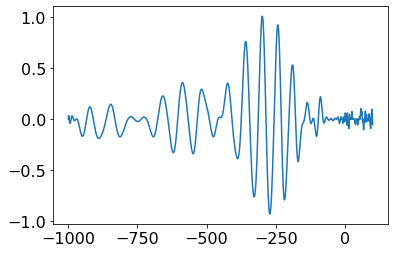

In [367]:
plt.figure()
plt.plot(default_times, amp_basis[5])

In [344]:
# 5.61693166 0.2759556  0.34943144

In [345]:
# 7.54913005 0.56533955 0.51985773

In [321]:
# 7.80468101 0.57136808 0.50962385

In [322]:
generators.cart_to_polar(0.57136808, 0,  0.50962385)

(0.7656225906618148, 0.8424542921096062, 0.0)

In [191]:
0.66 * 180/np.pi

37.81521447863434

In [192]:
60 * np.pi/180

1.0471975511965976

In [323]:
qs = [7.80468101 ]
chi1s = [0.7656225]
theta1s = [0.84245429]

In [324]:
# %%timeit
ts_times, ts_amp, ts_phase, ts_freq, coords = \
    generators.gen_3d_prec_single_spin_data(qs, chi1s, theta1s, 60, 1, deltaT=1./1024., npts=5000*10, t_min=-1000)
ts_hp = np.real(ts_amp * np.exp(-1.j * ts_phase))

In [325]:
coords

array([[7.80468101, 0.57136801, 0.50962379]])

In [326]:
ts_hp.shape

(1, 50000)

In [346]:
# %%timeit
sur_hp, sur_hc, samp, sphase, sur_times = wave_sur_many(coords[:,0], coords[:,1], coords[:,2], amp_model, amp_basis, phase_model, phase_basis, ts_times)

In [347]:
sur_hp.shape

(1, 50000)

In [348]:
ts_times.shape

(50000,)

In [349]:
sur_times.shape

(50000,)

(-100, 100)

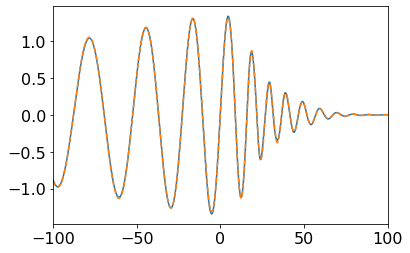

In [350]:
plt.figure()
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-100,100)

In [351]:
mask = ts_times > -1000
maxmatch = np.max(np.abs(match(ts_hp[0][mask], sur_hp[0][mask], ts_times[mask])))
print(maxmatch)

0.9998461524488588


In [352]:
maxmatch = np.max(np.abs(match(ts_hp[0], sur_hp[0], ts_times)))
print(maxmatch)

0.9998461463190356


(-1000, 100)

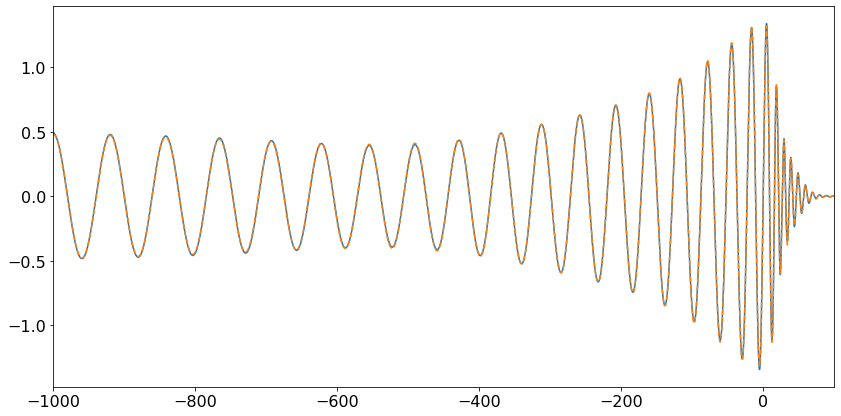

In [353]:
plt.figure(figsize=(14, 7))
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-1000,100)

(-100, 100)

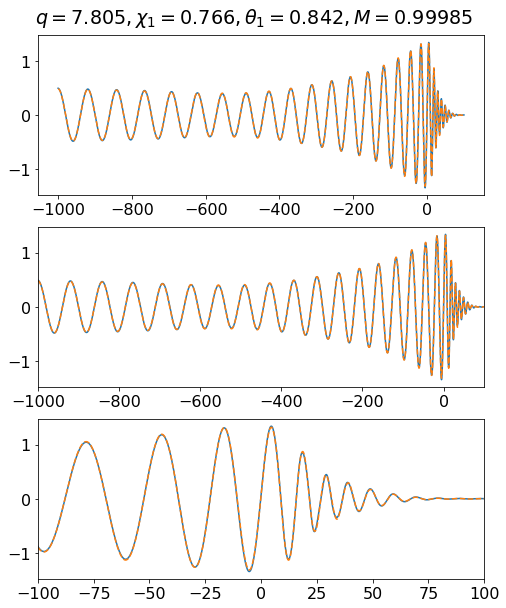

In [354]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
fig.suptitle(fr"$q = {qs[0]:.3f}, \chi_{{1}} = {chi1s[0]:.3f}, \theta_{{1}} = {theta1s[0]:.3f}, M = {maxmatch:.5f}$", y=0.92)
for ax in axes:
    ax.plot(ts_times, ts_hp[0])
    ax.plot(ts_times, sur_hp[0], ls='--')
axes[1].set_xlim(-1000,100)
axes[2].set_xlim(-100,100)
# plt.xlim(-1000,100)
# plt.title(fr"q = {qs[0]}, \chi = {chis[0]}")

(-100, 100)

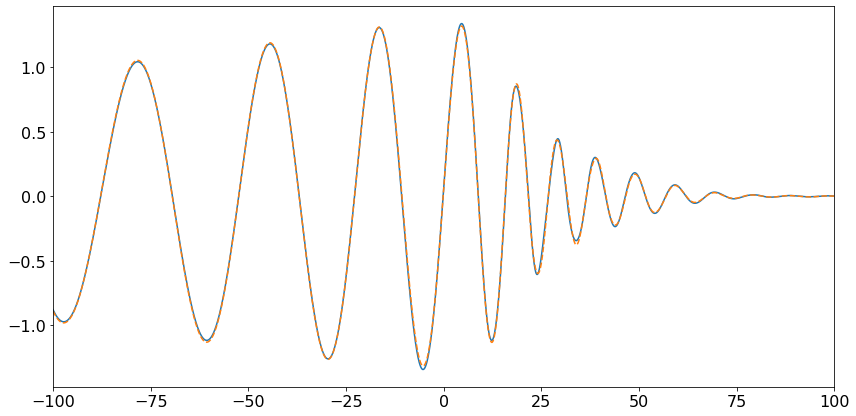

In [336]:
plt.figure(figsize=(14, 7))
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-100,100)
# plt.xlim(-1000,100)

(-100, 100)

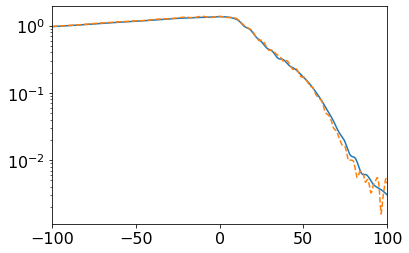

In [337]:
plt.figure()
plt.plot(ts_times, ts_amp[0])
plt.plot(ts_times, samp[0], ls='--')
plt.yscale('log')
plt.xlim(-100,100)

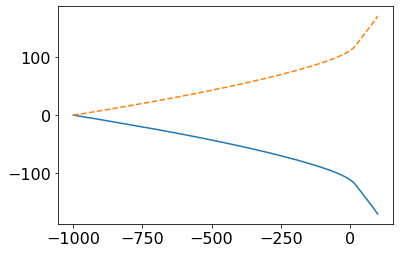

In [338]:
plt.figure()
plt.plot(ts_times, ts_phase[0])
plt.plot(ts_times, sphase[0], ls='--')
# plt.xlim(-100,100)

In [177]:
plt.figure()
plt.plot(ts_times, ts_phase[0]-sphase[0])
# plt.xlim(-100,100)

# gen eob data

In [311]:
# qs = [8]
# chi1s = [0.8]
# theta1s = [45*np.pi/180]

# qs = [8]
# chi1s = [0.8]
# theta1s = [110*np.pi/180]

qs = [7.5491300 ]
chi1s = [0.7680240]
theta1s = [0.8272847]

In [312]:
# %%timeit
ts_times, ts_amp, ts_phase, ts_freq, coords = \
    generators.gen_3d_prec_single_spin_data(qs, chi1s, theta1s, 60, 1, deltaT=1./1024., npts=5000*10)
ts_h = ts_amp * np.exp(-1.j * ts_phase)
ts_h_real = np.real(ts_h)
ts_h_imag = np.imag(ts_h)

In [313]:
plt.figure()
plt.plot(ts_times, ts_h_real[0])
plt.plot(ts_times, ts_h_imag[0])
plt.plot(ts_times, ts_amp[0])
plt.xlim(-100, 100)

(-100, 100)

In [314]:
plt.figure()
# plt.plot(ts_times, ts_h_real[0])
plt.plot(ts_times, ts_phase[0])
plt.xlim(-1000,100)

(-1000, 100)

In [315]:
plt.figure()
plt.plot(ts_times, ts_h_real[0])
plt.plot(ts_times, ts_h_imag[0])
plt.xlim(-100, 100)

(-100, 100)